In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

directory_path = "drive/MyDrive/NLP Demo"

filename = "Cybersecurity Survey - Fall 2022.xlsx"
file_path = os.path.join(directory_path, filename)


Sentence transformers and text clustering

In [3]:
## Text clustering
!pip install sentence_transformers
!pip install umap-learn
import pandas as pd
import umap
import nltk as nltk
import os






   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.9 MB/s eta 0:00:00


Turn paragraphs into sentences

In [7]:


import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


def cleaning(text):
    if isinstance(text, float):
        text = str(text)
    text = text.replace('\n', ' ')
    text = text.replace("It'\s", "It is")
    text = text.replace("it'\s", "it is")
    text = text.replace("it\'s", "it is")
    text = text.replace("n\'t", " not")
    text = text.replace("\'ll", " will")
    text = text.replace("\'m", " am")
    text = text.replace("\'ve", " have")
    text  = text.replace("I\'m", "I am")
    text = text.replace('.', '. ')
    text = text.replace('   ', ' ')
    text = text.replace(' ', ' ')
    text = text.replace('CDA3101', ' ')
    text = text.replace('CDA 3101', ' ')
    text = text.strip()

    return text

dat = pd.read_excel(file_path)
df = pd.DataFrame(dat)
corpus=df["Interesting"]
corpus






[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Interesting
0,I am interested in cloud security Present day...
1,If we’re going by technicality then yes I’m ...
2,No nothing is especially interesting about cyb...
3,I have taken a cybersecurity course before but...
4,nothing
...,...
1587,There is nothing especially interesting to me ...
1588,The most interesting part of cybersecurity to ...
1589,I think attacks are very interesting in the cl...
1590,I am not interested in cyber security but I ha...


Create sentence vectors

In [8]:

from sentence_transformers import SentenceTransformer
from functools import partial
model_path="all-mpnet-base-v2"
model = SentenceTransformer(model_path)
corpus_embeddings = model.encode(corpus.values)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Set up procedures, set parameters

In [13]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components,
                      min_cluster_size,
                      random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """

    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors,
                                n_components=n_components,
                                metric='euclidean',
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean',
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters
def score_clusters(clusters, prob_threshold = 0.1):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """

    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)

    return label_count, cost



def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize, which incorporates constraints
    on the number of clusters we want to identify
    """

    clusters = generate_clusters(embeddings,
                                 n_neighbors = params['n_neighbors'],
                                 n_components = params['n_components'],
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])

    label_count, cost = score_clusters(clusters, prob_threshold = 0.1)

    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.30
    else:
        penalty = 0

    loss = cost + penalty

    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayseian search on hyperopt hyperparameter space to minimize objective function
    """

    trials = Trials()
    fmin_objective = partial(objective, embeddings=embeddings, label_lower=label_lower, label_upper=label_upper)
    best = fmin(fmin_objective,
                space = space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print ("label count: {trials.best_trial['result']['label_count']}")

    best_clusters = generate_clusters(embeddings,
                                      n_neighbors = best_params['n_neighbors'],
                                      n_components = best_params['n_components'],
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])

    return best_params, best_clusters, trials

Run the clustering code

In [14]:
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials
!pip install hdbscan
import hdbscan
import numpy as np




hspace = {
    "n_neighbors":hp.choice('n_neighbors', range(3, 20)),
    "n_components": hp.choice('n_components', range(3, 20)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,20)),
    "random_state": 1
}

label_lower = 10
#was 10
label_upper = 100
max_evals = 30
best_params, best_clusters, trials = bayesian_search(corpus_embeddings,
                                                    space=hspace,
                                                    label_lower=label_lower,
                                                    label_upper=label_upper,
                                                    max_evals=max_evals)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



  3%|▎         | 1/30 [00:10<05:10, 10.70s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



  7%|▋         | 2/30 [00:15<03:23,  7.26s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 10%|█         | 3/30 [00:24<03:40,  8.16s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 13%|█▎        | 4/30 [00:31<03:12,  7.40s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 17%|█▋        | 5/30 [00:39<03:11,  7.66s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 20%|██        | 6/30 [00:47<03:11,  7.98s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 23%|██▎       | 7/30 [00:54<02:52,  7.48s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 27%|██▋       | 8/30 [01:02<02:48,  7.68s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 30%|███       | 9/30 [01:11<02:48,  8.04s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 33%|███▎      | 10/30 [01:21<02:53,  8.67s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 37%|███▋      | 11/30 [01:28<02:35,  8.19s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 40%|████      | 12/30 [01:36<02:28,  8.23s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 43%|████▎     | 13/30 [01:45<02:23,  8.46s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 47%|████▋     | 14/30 [01:52<02:05,  7.85s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 50%|█████     | 15/30 [01:59<01:57,  7.83s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 53%|█████▎    | 16/30 [02:07<01:50,  7.92s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 57%|█████▋    | 17/30 [02:15<01:41,  7.80s/trial, best loss: 0.3]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 60%|██████    | 18/30 [02:21<01:25,  7.14s/trial, best loss: 0.28957286432160806]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 63%|██████▎   | 19/30 [02:26<01:12,  6.63s/trial, best loss: 0.28957286432160806]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 67%|██████▋   | 20/30 [02:35<01:12,  7.29s/trial, best loss: 0.28957286432160806]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 70%|███████   | 21/30 [02:40<00:59,  6.62s/trial, best loss: 0.28957286432160806]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 73%|███████▎  | 22/30 [02:45<00:50,  6.29s/trial, best loss: 0.24309045226130654]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 77%|███████▋  | 23/30 [02:51<00:42,  6.01s/trial, best loss: 0.24309045226130654]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 80%|████████  | 24/30 [02:56<00:33,  5.64s/trial, best loss: 0.24309045226130654]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 83%|████████▎ | 25/30 [03:02<00:28,  5.76s/trial, best loss: 0.24309045226130654]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 87%|████████▋ | 26/30 [03:06<00:21,  5.47s/trial, best loss: 0.24309045226130654]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 90%|█████████ | 27/30 [03:11<00:15,  5.22s/trial, best loss: 0.24309045226130654]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 93%|█████████▎| 28/30 [03:20<00:12,  6.23s/trial, best loss: 0.24309045226130654]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 97%|█████████▋| 29/30 [03:27<00:06,  6.42s/trial, best loss: 0.24309045226130654]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



100%|██████████| 30/30 [03:35<00:00,  7.20s/trial, best loss: 0.24309045226130654]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



best:
{'min_cluster_size': 6, 'n_components': 11, 'n_neighbors': 4, 'random_state': 1}
label count: {trials.best_trial['result']['label_count']}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [15]:
best_clusters.labels_

array([-1, -1, 47, ..., -1, 46, 32])

In [ ]:
import matplotlib.pyplot as plt


def plot_clusters(embeddings, clusters, n_neighbors=13, min_dist=0.1):
    """
    Reduce dimensionality of best clusters and plot in 2D

    Arguments:
        embeddings: embeddings to use
        clusteres: HDBSCAN object of clusters
        n_neighbors: float, UMAP hyperparameter n_neighbors
        min_dist: float, UMAP hyperparameter min_dist for effective
                  minimum distance between embedded points

    """
    umap_data = umap.UMAP(n_neighbors=n_neighbors,
                          n_components=2,
                          min_dist = min_dist,
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])

    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()
plot_clusters(corpus_embeddings, best_clusters)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
result = pd.DataFrame(corpus)
result['category'] =best_clusters.labels_
result[result.category==9]
with pd.ExcelWriter("10cats_interesting.xlsx") as writer:
   result.to_excel(writer)

result

,Interesting,category
0,I am interested in cloud security Present day...,22
1,If we’re going by technicality then yes I’m ...,-1
2,No nothing is especially interesting about cyb...,24
3,I have taken a cybersecurity course before but...,-1
4,nothing,1
...,...,...
1587,There is nothing especially interesting to me ...,24
1588,The most interesting part of cybersecurity to ...,-1
1589,I think attacks are very interesting in the cl...,-1
1590,I am not interested in cyber security but I ha...,15


Sentiment analysis

In [ ]:


!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sent_analyzer(text):
      analyzer = SentimentIntensityAnalyzer()
      return analyzer.polarity_scores(text)


def vader_scores(feedbacktext, category):
      return vader.polarity_scores(feedbacktext).get(category)

vader = SentimentIntensityAnalyzer()


In [ ]:
corpus


,Interesting
0,I am interested in cloud security Present day...
1,If we’re going by technicality then yes I’m ...
2,No nothing is especially interesting about cyb...
3,I have taken a cybersecurity course before but...
4,nothing
...,...
1587,There is nothing especially interesting to me ...
1588,The most interesting part of cybersecurity to ...
1589,I think attacks are very interesting in the cl...
1590,I am not interested in cyber security but I ha...


In [ ]:
corpus = pd.DataFrame(corpus)
corpus["Negative_Score"] = corpus.apply(lambda row : vader_scores(corpus["Interesting"][row.name], "neg"),axis=1)
corpus["Positive_Score"] = corpus.apply(lambda row : vader_scores(corpus["Interesting"][row.name], "pos"),axis=1)
corpus["Neutral_Score"] = corpus.apply(lambda row : vader_scores(corpus["Interesting"][row.name], "neu"),axis=1)
corpus["Compound_Score"] = corpus.apply(lambda row : vader_scores(corpus["Interesting"][row.name], "compound"),axis=1)
corpus

,Interesting,Negative_Score,Positive_Score,Neutral_Score,Compound_Score
0,I am interested in cloud security Present day...,0.000,0.181,0.819,0.6249
1,If we’re going by technicality then yes I’m ...,0.000,0.214,0.786,0.8145
2,No nothing is especially interesting about cyb...,0.483,0.000,0.517,-0.5683
3,I have taken a cybersecurity course before but...,0.091,0.086,0.822,-0.0495
4,nothing,0.000,0.000,1.000,0.0000
...,...,...,...,...,...
1587,There is nothing especially interesting to me ...,0.101,0.000,0.899,-0.3559
1588,The most interesting part of cybersecurity to ...,0.000,0.193,0.807,0.7837
1589,I think attacks are very interesting in the cl...,0.146,0.301,0.553,0.4754
1590,I am not interested in cyber security but I ha...,0.074,0.240,0.686,0.5605


Word Cloud

In [ ]:
 def cleaning(self, string):
        import re
        #string  = string.lower() # step 1. lowercase

        string  = string.replace("can't", 'cannot') # step 3. replace abbreviated forms
        string = string.replace("n't", ' not')
        string  = string.replace("'ll", ' will')
        string  = string.replace("'m", ' am')
        string = string.replace("he's", "he is")
        string = string.replace("it's", 'it is')

        punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' # step 2. remove punctuations
        string  = string.strip(punc)


        return re.sub(r"\d+", "<DIGIT>", string) # step 4. replace all the numbers to <DIGIT>

def sent_tokenize(self, string):
        import nltk
        return nltk.sent_tokenize(string)

def tokenize(self, string):
        import nltk
        return nltk.word_tokenize(string)

def stemming(self, tokens):
        import nltk
        stemmer = nltk.stem.PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

def lemmatize(self, tokens):
        import nltk
        lemmatizer = nltk.stem.WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

def preprocess(self, string):
         df = self.import_data()
         df.interesting.apply(self.cleaning)
         df.relevant.apply(self.cleaning)
         return df

#normalizer = text_normalize() # call the text_normalize function and name it normalizer

stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()


from nltk.corpus import stopwords

nltk.download('stopwords')
from nltk.tokenize import word_tokenize

def removeStopWords(text):
  text_tokens = word_tokenize(text)
  #text_tokens = [stemmer.stem(token) for token in text_tokens]
  #text_tokens = [lemmatizer.lemmatize(token) for token in text_tokens]

  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
  return (" ").join(tokens_without_sw)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
words=corpus["Interesting"].apply(removeStopWords)
words

,Interesting
0,I interested cloud security Present day inform...
1,If ’ technicality I ’ interested video game de...
2,No especially interesting cybersecurity
3,I cybersecurity course I enjoy taking felt dig...
4,
...,...
1587,There especially interesting cybersecurity due...
1588,The interesting part cybersecurity extra chall...
1589,I attacks interesting clever ways circumvent e...
1590,I interested cyber security I interested topic


In [ ]:




bigstring=' '.join(words)

bigstring = bigstring.replace('class','')
bigstring = bigstring.replace('course','')
bigstring = bigstring.replace('programming','')
bigstring = bigstring.replace('program','')
bigstring = bigstring.replace('understand','')
bigstring = bigstring.replace('learn','')
bigstring = bigstring.replace('computer','')
bigstring = bigstring.replace('because','')
bigstring = bigstring.replace('topic','')
bigstring = bigstring.replace('science','')
bigstring = bigstring.replace(' I ','')
bigstring = bigstring.replace('like','')
bigstring = bigstring.replace('knowledge','')
bigstring = bigstring.replace('concept','')
bigstring = bigstring.replace('important','')
bigstring = bigstring.replace('different','')
bigstring = bigstring.replace('student','')
bigstring = bigstring.replace(' ed ','')
bigstring = bigstring.replace(' ing','')
bigstring = bigstring.replace('make','')
bigstring = bigstring.replace('interesting','')
bigstring = bigstring.replace('surprising','')
bigstring = bigstring.replace('included','')
bigstring = bigstring.replace(' thing','')
bigstring = bigstring.replace(' s ','')
bigstring = bigstring.replace(' S ','')





bigstring

"I interested cloud security Present day information stored cloud widely understood If ’ technicality’ interested video game development game projects stored susceptible leaks breaches So related cybersecurity No especially  cybersecuritycybersecurity enjoy taking felt digital law prefer coding  side    How vulnerabilities foundpersonal experience cross site scripting attacks relating white-hat hacking assess web applications collect bug bountiesfind amount steps required secure corporate network  At momentinterested cybersecurityCybercrime pretty   After victim cybercrimeedtargeted attacked From pointbegan grow interest Software Engineering cybersecurity What  easily hackers access persons personal informationfeel bitgeneral population   vulnerabilities existsafer online Nointerested exploit development OSCE3 certifcation`` white '' hacking cool basically paid company hack databasefeel cybersecurity futureinterested placeing website small holes website interests The idea hacking relat

In [ ]:
pip install wordcloud

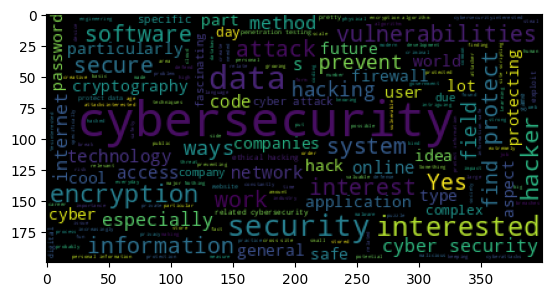

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud().generate(bigstring)
plt.imshow(wc)